## Imports & Formatting:

In [1]:
from signal_processing import pure_tone_complex, sound, magphase, get_spect, magphase
import matplotlib.pyplot as plt
from scipy.signal import spectrogram as sp
import scipy as scip
import numpy as np

#Formatting (to center plots):
from IPython.display import display, HTML
import IPython.display as ipd

CSS = """
.output {
    align-items: center;
}
"""

HTML('<style>{}</style>'.format(CSS))

## F0_DL Discrimination Task Stimuli:

### Idea: 
   - Testing perceptual/psychophysical properties of pitch. How does cochlear impairment impact pitch discriminability

### TODO:
   - Parameterize nicely
   - Add noise to reduce distortion products?
   - Buzziness at high frequencies...should all harmonics be same magnitude or should there be a decay?

In [2]:
from scipy import signal

def pitch_discrim(F0 = 250, shift = 1e-2, atten = 0.5, harm_rank = 3, tot_harm = 5, spacing = 0.03, dur_sec = 0.5, ramp_dur = 0.2, fs = 44100, phase = 'alt'):
    freq_Hz1 = np.arange(harm_rank,tot_harm+1)*F0;
    freq_Hz2 = freq_Hz1*(1+shift);
    mags = np.ones(len(freq_Hz1))*freq_Hz1**-1.3;

    #exponentially drop harmonic mags
    #mags = atten*np.ones(len(freq_Hz1))*np.exp(-np.arange(0,len(freq_Hz1)));

    
    if phase == 'sin':
        phi = np.zeros(len(freq_Hz1));
    else:
        phi = np.zeros(len(freq_Hz1))+np.pi/2*(np.arange(len(freq_Hz1))%2);

    space = np.zeros(round(spacing*fs));

    ham_win = np.hamming(round(dur_sec*fs*ramp_dur));
    ham = np.concatenate([ham_win[0:round(len(ham_win)/2)],np.ones(round((dur_sec*(1-ramp_dur))*fs)), 
                          ham_win[round(len(ham_win)/2):len(ham_win)]]);

    F_1 = pure_tone_complex(freq_Hz1, fs, dur_sec, mags, phi)
    F_2 = pure_tone_complex(freq_Hz2, fs, dur_sec, mags, phi)

    signal = np.concatenate([ham*F_1[1],space,ham*F_2[1],space,ham*F_1[1],space,ham*F_2[1],space]);
    signal = atten*signal/np.max(signal);

    time = np.arange(0,dur_sec*4,1/fs);

    return signal, time;



#Harmonic Rank Sequence:
def rank_sequence(F0 = 100, ranks = [1,3,5,7,9], harms = 3, epoch_dur = .25, spacing = 0.3, ramp_dur = 0.2, fs = 44100, phase = 'sin'):
    signal = [];
    for r in range(len(ranks)):
        freqs = np.arange(ranks[r],ranks[r]+harms)*F0;
        #toggle for decay
        #mags = np.ones(len(freqs))*freqs**-1.3;
        mags = np.ones(len(freqs));
        
        if phase == 'sin':
            phi = np.zeros(len(freqs));
        else:
            phi = np.zeros(len(freqs))+np.pi/2*(np.arange(len(freqs))%2);
            
        space = np.zeros(round(spacing*fs));
        ham_win = np.hamming(round(epoch_dur*fs*ramp_dur));
        ham = np.concatenate([ham_win[0:round(len(ham_win)/2)],np.ones(round((epoch_dur*(1-ramp_dur))*fs)), 
                          ham_win[round(len(ham_win)/2):len(ham_win)]]);
        
        tone = pure_tone_complex(freqs, fs, epoch_dur, mags, phi);
        signal = np.concatenate([signal,ham*tone[1],space]);
        
        
        
    time = np.arange(0,dur_sec*4,1/fs);
    return signal, time;

#Harmonic Frequency Modulation:
def hfm(F0 = 250, a_mod = 100, rate_mod = 1, harm_rank = 3, tot_harm = 15, dur_sec = 5, atten = 0.3, fs = 44100, ramp_dur = 0.2, phase = 'sin', noise_on = False, noise_cutoff = 21e2, noise_atten = 0.02):
    samples = np.arange(0,fs*dur_sec);
    time_sec = samples/fs;
    harm_no = np.arange(harm_rank,tot_harm+1);
    mags = atten*np.ones(len(harm_no));

    #[OPTIONAL] decay to reduce buzziness
    mags = np.ones(len(harm_no))*(F0*harm_no)**-1.3;
    mags = atten*mags/mags[0];
    
    if phase == 'sin':
        phi = np.zeros(len(harm_no));
    else:
        phi = np.zeros(len(harm_no))+np.pi/2*(harm_no%2);  
        
    for i in range(len(harm_no)):
        amp_mod = a_mod*(harm_no[i]);
        F0_temp = F0*harm_no[i];
        mod = amp_mod*np.sin(2*np.pi*rate_mod*time_sec + np.pi);
        sig_temp = mags[i]*np.sin(2*np.pi*F0_temp*time_sec + mod/rate_mod + phi[i]);
        #sig_temp = mags[i]*np.sin(2*np.pi*F0_temp*time_sec + mod/rate_mod);
        
        sig_arr = np.array(sig_temp)

        if i==0:
            sig = sig_arr;
        else:
            sig = sig + sig_arr;
    
    sig = atten*sig/rms(sig);
    
    if noise_on == True:
        noise_bb = np.random.normal(0,1,size = len(sig));
        sos = signal.butter(80, noise_cutoff, 'lp', fs=fs, output = 'sos');
        noise = signal.sosfilt(sos, noise_bb);
        noise = noise_atten*noise/rms(noise);
        sig = sig + noise;
        sig = atten*sig/rms(sig);
    
    #ramp
    ham_win = np.hamming(round(dur_sec*fs*ramp_dur));
    ham = np.concatenate([ham_win[0:round(len(ham_win)/2)],np.ones(round((dur_sec*(1-ramp_dur))*fs)), 
                          ham_win[round(len(ham_win)/2):len(ham_win)]]);        
    sig = ham*sig;
    
    return sig, time_sec;


######Add these to signal_processing.py!!!!#################################
def mag2db(x):
    db_out = 20*np.log10(x);
    return db_out;

def db2mag(x):
    mag_out = 10**(x/20);
    return mag_out;
    
def rms(vector):
    rmsval = np.sqrt(np.mean(np.square(vector)));
    return rmsval;

/mnt/ECF4E22CF4E1F92A/Research/Code/Python_Coding_Toolbox/signal_processing/pitch/signal_processing.py:268: UserWarning: shading value 'goraud' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolormesh(t,f,Sgram_dB, shading = shading, cmap = colormap);


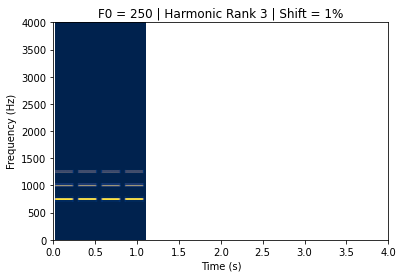

In [3]:
F0 = 250;
shift = 0.001;
harm_rank = 16;
tot_harm = 18;

fs = round(50e6/1024);
atten = .5;
spacing = .03;
dur_sec = .25;
ramp_dur = 0.2;
phase = 'sin';

###################################################################################################################
sig, time = pitch_discrim(F0 = F0, fs = fs, spacing = spacing, dur_sec = dur_sec, shift = shift, phase = phase);
get_spect(sig, fs, DR = 30, BW = 100, xlim = [0,4], ylim = [0,4e3], 
          colormap = 'cividis', title = 'F0 = 250 | Harmonic Rank 3 | Shift = 1%');
#sound(sig,fs,fname = 'f0_100_rank3_max5_PT_sin.wav', savefile = 1)
ipd.Audio(sig, rate = fs)

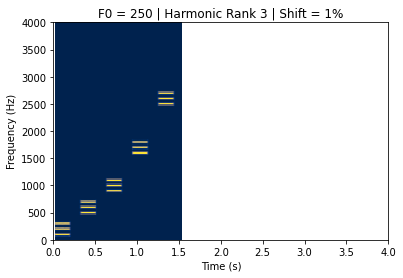

In [12]:
fs = round(50e6/1024);
#fs = 44100;
F0 = 100;
phase = 'alt';
ranks = [1,5,9,16,25];
harms = 3;

rankstim, time = rank_sequence(F0 = F0, ranks = ranks, harms = harms, epoch_dur = 0.21, spacing = 0.1, fs = fs, phase = phase);

rankstim = rankstim/max(abs(rankstim));

get_spect(rankstim, fs, DR = 30, BW = 100, xlim = [0,4], ylim = [0,4e3], 
          colormap = 'cividis', title = 'F0 = 250 | Harmonic Rank 3 | Shift = 1%');

fname = 'F0_' + str(F0) + '_ranks_' + str(len(ranks)) + '_harms_' + str(harms) + '_phase_' + phase + '.wav'; 
sound(rankstim,fs,fname = fname, savefile = 1)
#ipd.Audio(rankstim, rate = fs)

In [ ]:
from scipy.io import savemat
import os

#Generate mat with a given pitch shift for several harmonic ranks:
F0 = 300; #arbitrarily chosen
shifts = np.arange(0,0.1,0.005); #set as a ratio (i.e. 1 = octave)
ranks = np.arange(3,16,2);
fs = 44.1e3;
dur = .25;
spacing = 0.03;
tot_samps = round((dur+spacing)*4*fs);
stim_mat = np.zeros((len(shifts), len(ranks),tot_samps));
phase = 'sin';

orig = os.getcwd();
stim_dir = os.getcwd() + '/Stimuli/Harmonic_Rank';
print(stim_dir)

for s in range(len(shifts)):
     for r in range(len(ranks)):
        tot_harm = ranks[r]+2;
        sig, time = pitch_discrim(F0 = F0, fs = fs, spacing = spacing, dur_sec = dur, harm_rank = ranks[r], tot_harm = tot_harm, shift = shifts[s], phase = phase);
        stim_mat[s][r] = sig;
        
get_spect(stim_mat[0][0], fs, DR = 30, BW = 100, xlim = [0,tot_samps/fs], ylim = [0,4e3], 
          colormap = 'Reds');

mat_out = {"Stimuli": stim_mat, "Shifts": shifts, "Ranks": ranks, "SampleRate": fs};

file_out = 'F0_' + str(F0) + '_' + phase + '.mat';
os.chdir(stim_dir);
savemat(file_out,mat_out)
os.chdir(orig);


## FM Harmonic Tone Complex Stimuli:
### Idea: 
   - Not a directly perceptual measure, ideally directly correlates with pitch coding
   - Won't be measuring FFR at discrete frequencies, rather measures the ability to track a moving pitch with varying harmonic rank. Could also add masking. 
   - See if Dave Axe's FFR findings in carbo chins (i.e. poorer FM coding) extend to pitch stimuli

### TODO:
   - Same as above
   - Math check...basic trig 
   - Spectrogram auto-title

In [ ]:
%matplotlib inline

F0 = 500;
a_mod = 300;
rate_mod = 1/.3;
speed = 'slow';
harm_rank = 1;
tot_harm = 5;
fs = round(50e6/1024);
dur_sec = 1.2;
atten = 1;
SNR_db = 20;
offset = 100e-3;
phs = 'alt';

noise_atten = 1/(db2mag(SNR_db)*atten);
signal2, time2 = hfm(F0 = F0, atten = atten, tot_harm = tot_harm, phase = phs,
                     a_mod = a_mod, harm_rank = harm_rank, fs = fs, 
                     rate_mod = rate_mod, dur_sec = dur_sec, ramp_dur = 0.2, 
                     noise_on = True, noise_atten = noise_atten, noise_cutoff = 3*F0)

pause = np.zeros(round(offset*fs));
sig2 = np.concatenate([signal2,pause]);
time = np.arange(0,len(sig2)/fs,1/fs);

fname = 'f0' + str(F0) + '_' + speed + '_depth' + str(a_mod) + '_rank' + str(harm_rank) + '_max' + str(tot_harm) + '_dbSNR' + str(SNR_db) + '_' + phs + '.wav';
get_spect(sig2, fs, DR = 200, BW = 200, xlim = [0,1.3], ylim = [0,5e3], 
           colormap = 'Reds', title = fname);


sig2 = sig2/max(abs(sig2));
plt.figure()
plt.plot(time,sig2)
plt.xlim([.53,.57])

sound(sig2,fs,fname = fname, savefile = 1)
#ipd.Audio(sig2, rate = fs)
